<a href="https://colab.research.google.com/github/ryanmdpeters21/Data-Analysis/blob/main/Football_Analytics_with_Python_chap5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nfl_data_py
!pip install numpy
!pip install nfl_data_py
!pip install statsmodels
!pip install matplotlib
!pip install seaborn

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.8 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13187 sha256=f74ec7d438f3b06ad839f124a20f817e331ef7b048aa188c22a9c99c950231dc
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py


In [2]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# We want to examine to effectiveness of QBs similar to how we did with RBs.
# We will look at completion percentage over expected.
# We have installed and import all relevant packages for this.
# We can now load in our data.
seasons = range(2016, 2022+1)
pbp_py = nfl.import_pbp_data(seasons)

pbp_py_pass = \
  pbp_py\
  .query('play_type == "pass" & passer_id.notnull() &' +
         'air_yards.notnull()')\
  .reset_index()

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


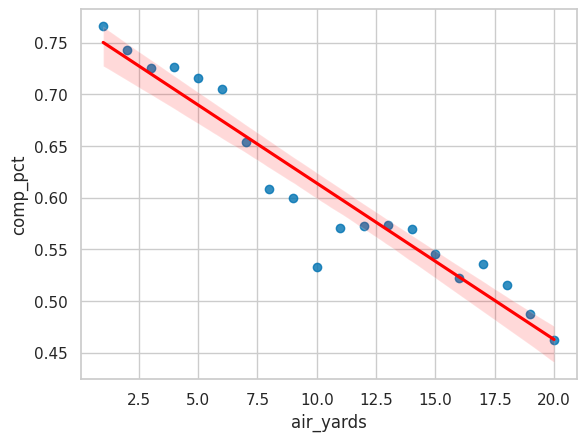

In [5]:
# Now we want to restrict air yards to be >0 and =<20.
# We will also summarize our data to calculate compeltion percentage, comp_pct
sns.set_theme(style='whitegrid', palette='colorblind')

# Format and then plot
pass_pct_py =\
  pbp_py_pass\
  .query('0 < air_yards <= 20')\
  .groupby('air_yards')\
  .agg({'complete_pass': ['mean']})

pass_pct_py = \
  pbp_py_pass\
  .query('0 < air_yards <= 20')\
  .groupby('air_yards')\
  .agg({'complete_pass': ['mean']})

pass_pct_py.columns = \
  list(map('_'.join, pass_pct_py.columns))

pass_pct_py\
  .reset_index(inplace=True)
pass_pct_py\
  .rename(columns={'complete_pass_mean': 'comp_pct'},
                    inplace=True)

sns.regplot(data=pass_pct_py, x='air_yards', y='comp_pct',
            line_kws={'color': 'red'});
plt.show()

In [6]:
# Let's try building our first GLM.
# A GLM is a generalized linear model.
# It allows for response variabls that come from non-normal distribution (ie. binary or counts)
# We wil use the glm() function to create a GLM model.
complete_ay_py =\
  smf.glm(formula='complete_pass ~ air_yards',
          data=pbp_py_pass,
          family=sm.families.Binomial())\
          .fit();

complete_ay_py.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          complete_pass   No. Observations:               131606
Model:                            GLM   Df Residuals:                   131604
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -81073.
Date:                Fri, 05 Jan 2024   Deviance:                   1.6215e+05
Time:                        02:31:27   Pearson chi2:                 1.32e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07013
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0720      0.008    133.306      0.000       1.056       1.088
air_yards     -0.0573      0.001    -91.806      0.000      -0.059      -0.056
==============================================================================
"""

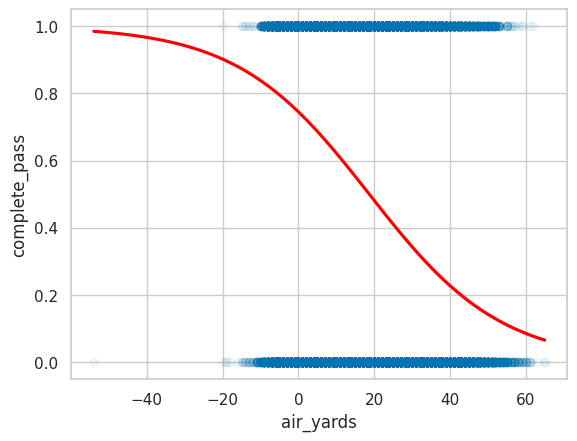

In [7]:
# Let's try with logistic regression
sns.regplot(data=pbp_py_pass, x='air_yards', y='complete_pass',
            logistic=True,
            line_kws={'color': 'red'},
            scatter_kws={'alpha':0.05});
plt.show();

In [8]:
# We will use the .predict() function to extract the predicted value from the model
# we previously fit and then subtract from the observed value to calculate CPOE
pbp_py_pass['exp_completion'] = \
  complete_ay_py.predict()

pbp_py_pass['cpoe'] = \
  pbp_py_pass['complete_pass'] - \
  pbp_py_pass['exp_completion']

In [9]:
# Let's look at QBs w/ 100 or more attempts.
# We will filter out NA data.
# Let's calculate the mean CPOE and mean completed pass perceentage and then sort by compl.
cpoe_py = \
  pbp_py_pass\
  .groupby(['season', 'passer_id', 'passer'])\
  .agg({'cpoe': ['count', 'mean'],
        'complete_pass': ['mean']})

cpoe_py.columns = \
  list(map('_'.join, cpoe_py.columns))
cpoe_py.reset_index(inplace=True)

cpoe_py = \
  cpoe_py\
  .rename(columns = {'cpoe_count': 'n',
                     'cpoe_mean': 'cpoe',
                     'complete_pass_mean': 'compl'})\
    .query('n > 100')

print(
    cpoe_py\
      .sort_values('cpoe', ascending=False)
)

     season   passer_id      passer    n      cpoe     compl
299    2019  00-0020531     D.Brees  406  0.094099  0.756158
193    2018  00-0020531     D.Brees  566  0.086476  0.738516
467    2020  00-0033537    D.Watson  542  0.073453  0.704797
465    2020  00-0033357      T.Hill  121  0.072505  0.727273
22     2016  00-0026143      M.Ryan  631  0.068933  0.702060
..      ...         ...         ...  ...       ...       ...
91     2016  00-0033106      J.Goff  204 -0.108739  0.549020
526    2021  00-0027939    C.Newton  126 -0.109908  0.547619
112    2017  00-0025430   D.Stanton  159 -0.110229  0.496855
730    2022  00-0037327  S.Thompson  150 -0.116812  0.520000
163    2017  00-0031568     B.Petty  112 -0.151855  0.491071

[300 rows x 6 columns]


In [11]:
# Let's try adding more variables into our equation.
# We add down, distance to first down, distance to endzone, pass location, and qb_hit.
# We will change our variables to factors, select our columns, and then drop NA values.
pbp_py_pass['down'] = pbp_py_pass['down'].astype(str)
pbp_py_pass['qb_hit'] = pbp_py_pass['qb_hit'].astype(str)

pbp_py_pass_no_miss = \
  pbp_py_pass[['passer', 'passer_id', 'season',
               'down', 'qb_hit', 'complete_pass',
               'ydstogo', 'yardline_100',
               'air_yards', 'pass_location']]\
               .dropna(axis = 0)

In [12]:
# We can now start to build and fit our model in python
complete_more_py = \
  smf.glm(formula='complete_pass ~ down * ydstogo + ' +
                  'yardline_100 + air_yards + ' +
                  'pass_location + qb_hit',
          data=pbp_py_pass_no_miss,
          family=sm.families.Binomial())\
          .fit()

In [13]:
# Now we can extract the outputs and calculate the CPOE.
pbp_py_pass_no_miss['exp_completion'] = \
  complete_more_py.predict()

pbp_py_pass_no_miss['cpoe'] = \
  pbp_py_pass_no_miss['complete_pass'] - \
  pbp_py_pass_no_miss['exp_completion']

In [14]:
# Now let's summarize our outputs, and rename the columns.
cpoe_py_more = \
  pbp_py_pass_no_miss\
  .groupby(['season', 'passer_id', 'passer'])\
  .agg({'cpoe': ['count', 'mean'],
        'complete_pass': ['mean'],
        'exp_completion': ['mean']})

cpoe_py_more.columns = \
  list(map('_'.join, cpoe_py_more.columns))
cpoe_py_more.reset_index(inplace=True)

cpoe_py_more = \
  cpoe_py_more\
  .rename(columns = {'cpoe_count': 'n',
                     'cpoe_mean': 'cpoe',
                     'complete_pass_mean': 'compl',
                     'exp_completion_mean': 'exp_completion'})\
  .query('n > 100')

In [15]:
# Now we can print our table
print(
    cpoe_py_more\
    .sort_values('cpoe', ascending=False)
)

     season   passer_id    passer    n      cpoe     compl  exp_completion
193    2018  00-0020531   D.Brees  566  0.088924  0.738516        0.649592
299    2019  00-0020531   D.Brees  406  0.087894  0.756158        0.668264
465    2020  00-0033357    T.Hill  121  0.082978  0.727273        0.644295
22     2016  00-0026143    M.Ryan  631  0.077565  0.702060        0.624495
467    2020  00-0033537  D.Watson  542  0.072763  0.704797        0.632034
..      ...         ...       ...  ...       ...       ...             ...
390    2019  00-0035040  D.Blough  174 -0.100327  0.540230        0.640557
506    2020  00-0036312   J.Luton  110 -0.107358  0.545455        0.652812
91     2016  00-0033106    J.Goff  204 -0.112375  0.549020        0.661395
526    2021  00-0027939  C.Newton  126 -0.123251  0.547619        0.670870
163    2017  00-0031568   B.Petty  112 -0.166726  0.491071        0.657798

[300 rows x 7 columns]


In [17]:
# Is CPOE more stable than completion percentage? Let's find out.
# We want to be sure we are isolating a player's performance more than his conditions.
# We can tackle this by calculating lag between current CPOE and last years CPOE.
cols_keep = \
  ['season', 'passer_id', 'passer',
   'cpoe', 'compl', 'exp_completion']

# Create current df.
cpoe_now_py = \
  cpoe_py_more[cols_keep].copy()

# Create last year's df.
cpoe_last_py = \
  cpoe_now_py[cols_keep].copy()

# Rename columns.
cpoe_last_py\
  .rename(columns = {'cpoe': 'cpoe_last',
                     'compl': 'compl_last',
                     'exp_completion': 'exp_completion_last'},
                      inplace=True)

# Add one to season
cpoe_last_py['season'] += 1

# Merge together
cpoe_lag_py = \
  cpoe_now_py\
  .merge(cpoe_last_py,
         how='inner',
         on=['passer_id', 'passer',
             'season'])

In [18]:
# We can now examine the correlation for pass completion
cpoe_lag_py[['compl_last', 'compl']].corr()

,compl_last,compl
compl_last,1.000000,0.445465
compl,0.445465,1.000000


In [20]:
# We can now examine the correlation for pass completion
cpoe_lag_py[['cpoe_last', 'cpoe']].corr()

,cpoe_last,cpoe
cpoe_last,1.000000,0.464974
cpoe,0.464974,1.000000
